In [67]:
# Parallel workers
num_workers = 4
num_clients = 2

client_starts = []
client_durations = []
for _ in range(num_clients):
  client_starts.append([])
  client_durations.append([])

for i in range(num_workers):
  with open('results/results_' + str(i) + '.txt', 'r') as file:
    # Iterate over each line in the file
    execution_order = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
    for j in range(num_clients):
      client_durations[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])
    for j in range(num_clients):
      client_starts[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])

absolute_start = min(client_starts[0] + client_starts[1])
for i in range(len(client_starts)):
  client_durations[i] = [y for _, y in sorted(zip(client_starts[i], client_durations[i]))]
  client_starts[i] = sorted(client_starts[i])
  client_starts[i] = [start - absolute_start for start in client_starts[i]]

In [ ]:
# Pipelined workers
num_workers = 4
num_clients = 2

client_starts = []
client_durations = []
for _ in range(num_clients):
  client_starts.append([])
  client_durations.append([])

for i in range(num_workers):
  with open('results/results_' + str(i) + '.txt', 'r') as file:
    # Iterate over each line in the file
    execution_order = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
    for j in range(num_clients):
      client_durations[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])
    for j in range(num_clients):
      client_starts[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])

absolute_start = min(client_starts[0] + client_starts[1])
for i in range(len(client_starts)):
  client_durations[i] = [y for _, y in sorted(zip(client_starts[i], client_durations[i]))]
  client_starts[i] = sorted(client_starts[i])
  client_starts[i] = [start - absolute_start for start in client_starts[i]]

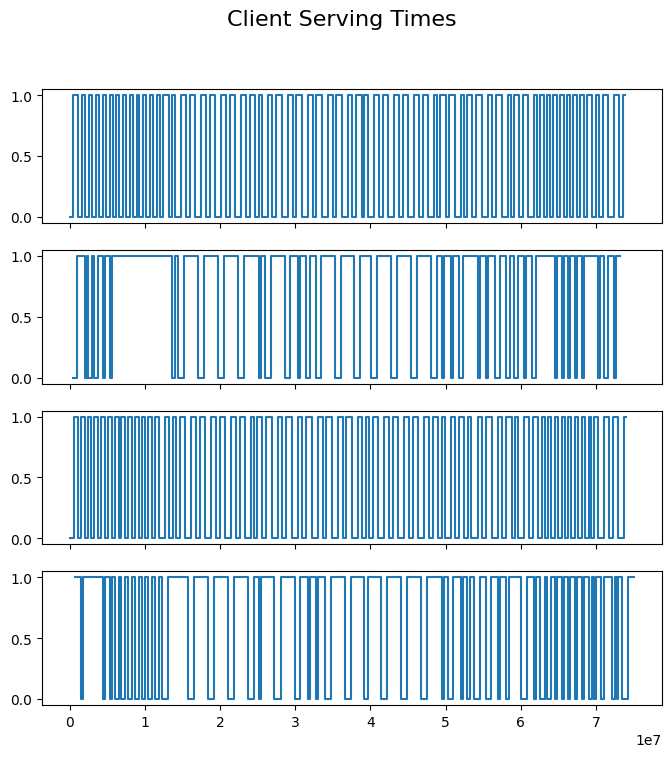

In [68]:
# First attempt: Plot each worker's execution order
# Issue: this merges together sequential ops of same client
worker_executions = []
worker_starts = []

for i in range(num_workers):
  with open('results/results_' + str(i) + '.txt', 'r') as file:
    # Iterate over each line in the file
    worker_executions.append([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])
    for j in range(num_clients):
      _ = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
    worker_starts.append([])
    for j in range(num_clients):
      worker_starts[i].append([int(x) - absolute_start for x in file.readline().strip().split(':')[1].split(',')[:-1]])

worker_timelines = []
for i in range(len(worker_executions)):
  client_counts = [0, 0]
  exec_order = worker_executions[i]
  worker_timelines.append([])
  for client in exec_order:
    worker_timelines[i].append(worker_starts[i][client][client_counts[client]])
    client_counts[client] += 1

def stepify(x, y):
  # for every xn, yn: need an xn+1,yn
  new_x = [x[0]]
  new_y = []
  for i in range(1, len(x)):
    new_x.append(x[i])
    new_x.append(x[i])
  new_x.append(new_x[-1])
  for i in range(len(y)):
    new_y.append(y[i])
    new_y.append(y[i])
  return new_x, new_y

  # Worker 1's (idx 0's) execution order
# x-axis: time
# y-axis: client serving

import matplotlib.pyplot as plt

fig, axarr = plt.subplots(4, 1, sharex=True, sharey=True,figsize=(8, 8))

for i in range(len(worker_timelines)):
  x, y = stepify(worker_timelines[i], worker_executions[i])
  axarr[i].plot(x, y, label=f'Worker ' + str(i))

fig.suptitle('Client Serving Times', fontsize=16)
plt.show()

In [94]:
interval_seconds = 3

def chunk(starts):
  chunked_starts = [0]
  time_interval = interval_seconds * 1000000
  cur_time = -1
  for i in range(len(starts)):
    start = starts[i]
    if start > cur_time + time_interval:
      while start > cur_time + time_interval:
        chunked_starts.append(0)
        cur_time += time_interval
      chunked_starts[-1] = 1
    else:
      chunked_starts[-1] += 1
  return chunked_starts

client1_chunked_starts = chunk(client_starts[0])
client2_chunked_starts = chunk(client_starts[1])
print(client1_chunked_starts)
print(client2_chunked_starts)

# disk,cpu - 1,4 - 3,1 - out of 9/18
# client1_disk_util = [100 * 1/9 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]
# client1_cpu_util = [100 * 4/18 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]

# client2_disk_util = [100 * 3/9 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]
# client2_cpu_util = [100 * 1/18 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]

client1_disk_util = [100 * 1/3 * 1/3 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]
client1_cpu_util = [100 * 2/3 * 1/4 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]

# TODO: I think this is under-counting CPU because of disk wait
#       Use this to articifially inflate based on total read time
# client1_cpu_util = [100 * 2/3 * 40/132 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]

# 2/3s per op, 132/40 core seconds

client2_disk_util = [100 * 3/9 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]
client2_cpu_util = [100 * 1/24 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]

[4, 3, 4, 3, 4, 3, 4, 4, 3, 4, 3, 4, 4, 3]
[6, 5, 5, 6, 5, 5, 6, 5, 5, 2]


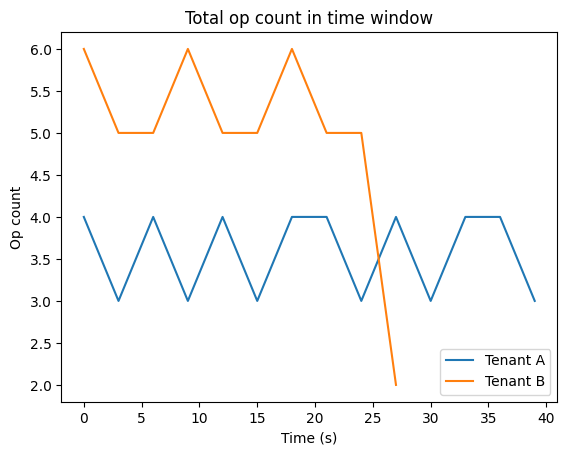

In [92]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('Total op count in time window')
ax.set_ylabel('Op count')
ax.set_xlabel('Time (s)')
# ax.set_ylim(0,100)

ax.plot([x * interval_seconds for x in list(range(len(client1_chunked_starts)))], client1_chunked_starts, label='Tenant A')
ax.plot([x * interval_seconds for x in list(range(len(client2_chunked_starts)))], client2_chunked_starts, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

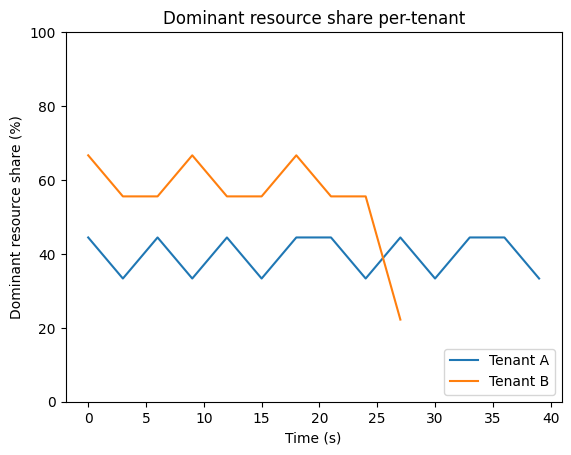

In [93]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('Dominant resource share per-tenant')
ax.set_ylabel('Dominant resource share (%)')
ax.set_xlabel('Time (s)')
ax.set_ylim(0,100)

# how_many = 30
# how_many = len(client1)
# x_axis = list(range(how_many))
# x_axis = [x * 3 for x in list(range(how_many))]

ax.plot([x * interval_seconds for x in list(range(len(client1_cpu_util)))], client1_cpu_util, label='Tenant A')
ax.plot([x * interval_seconds for x in list(range(len(client2_disk_util)))], client2_disk_util, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

In [ ]:
# Metrics:
# Dominant resource share over time

In [95]:
# Per-client QPS
for i in range(len(client_starts)):
  starts = client_starts[i]
  run_start = starts[0]
  run_end = starts[-1] + client_durations[i][-1]
  qpus = len(starts) / (run_end - run_start)
  qps = qpus * 1000000
  print(f'Client {i} QPS = {qps}')

Client 0 QPS = 1.193265220640825
Client 1 QPS = 1.7748885432115962


In [78]:
a_cpu_cost = 1/4
b_cpu_cost = 1/4
a_disk_cost = 1
b_disk_cost = 1/2

core_resources = 2
disk_resouces = 4.42

# Per-client QPS
for i in range(len(client_starts)):
  starts = client_starts[i]
  run_start = starts[0]
  run_end = starts[-1] + client_durations[i][-1]
  qpus = len(starts) / (run_end - run_start)
  qps = qpus * 1000000
  print(f'Client {i} QPS = {qps}')
  
# Total system utilization
# CPU: total compute time used / total time of experiment * 2 CPUs
cpu_usage = 0
cpu_usage += a_cpu_cost * len(client_starts[0]) / 2
cpu_usage += b_cpu_cost * len(client_starts[1]) / 2

disk_usage = 0
disk_usage += a_disk_cost * len(client_starts[0]) / 2
disk_usage += b_disk_cost * len(client_starts[1]) / 2
print(len(client_starts[0]))  # 250 - 250GB
print(len(client_starts[1]))  # 250 - 125GB

run_duration_us = max(client_starts[0][-1] + client_durations[0][-1], client_starts[1][-1] + client_durations[1][-1])
run_duration_s = run_duration_us / 1000000
print(f'Total run duration: {run_duration_s}s')

cpu_util = cpu_usage / (run_duration_s * core_resources)
print(f'CPU util: {cpu_util}')

cpu_util2 = cpu_usage / (run_duration_s * core_resources - disk_usage/disk_resouces)
print(f'CPU util w/o disk: {cpu_util2}')

disk_util = disk_usage / (run_duration_s * disk_resouces)
print(f'Disk util: {disk_util}')


Client 0 QPS = 4.49758997852926
Client 1 QPS = 8.890705238906799
334
666
Total run duration: 75.263426s
CPU util: 0.8304166222781302
CPU util w/o disk: 1.665015785483967
Disk util: 1.0025120127773988


In [97]:
# Dominant resource share over time
# 1. every Xs, how many ongoing ops are there? multiple this by resource usage and determine dominant share
# 2. sliding window of Xs, how may resources were used in this interval?

# 1
# for each client
# 
# let's say every 100ms
interval_us = 1000000  # in microseconds (100ms)
num_interval = 42  # duration of experiment
intervals_us = [interval_us * t for t in range(1,num_interval)]
client_counts = []
for i in range(len(client_starts)):
  client_counts.append([0] * len(list(range(1, num_interval))))

for i in range(len(intervals_us)):
  t = intervals_us[i]
  # find all the ops that were ongoing at this point in time
  for j in range(len(client_starts)):
    starts = client_starts[j]
    durs = client_durations[j]
    # print(len(starts), len(durs))
    for k in range(len(starts)):
      start = starts[k]
      dur = durs[k]
      if start > t:
        break
      if start + dur < t:
        continue
      if start <= t and start + dur > t:
        client_counts[j][i] += 1

# interval_available_cpu = 2 * interval_us  # 2 cores
# interval_available_disk = 3 * interval_us / 1000000  # 3 GB/s (3KB/us)

for counts in client_counts:
  print(counts)

client1_cpu_share = [100 * 2/3 * x / 2 for x in client_counts[0]]  # 2 cores

# Without disk:
# client1_cpu_share = [100 * 2/3 * x / 3.3 for x in client_counts[0]]
# print(client1_disk_share)
print(client1_cpu_share)

client2_disk_share = [100 * 1 * x / 3 for x in client_counts[1]]
# client2_cpu_share = [100 * 1/12 * x / 2 for x in client_counts[1]]
print(client2_disk_share)
# print(client2_cpu_share)

# client1_disk_util = [100 * 1/9 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]
# client1_cpu_util = [100 * 4/18 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]

# client2_disk_util = [100 * 3/9 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]
# client2_cpu_util = [100 * 1/18 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.333333333333336, 33.33333333

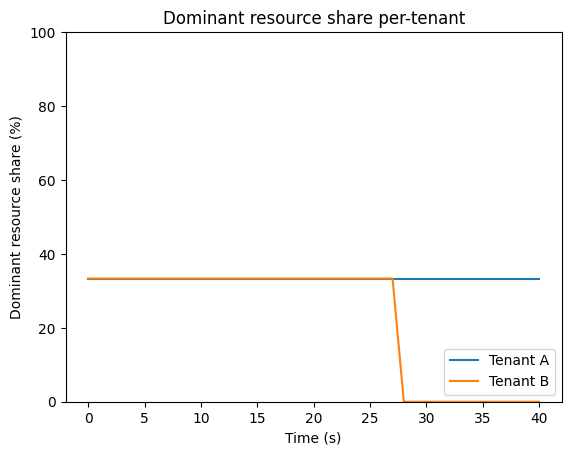

In [98]:
import matplotlib.pyplot as plt

# 1. every Xs, how many ongoing ops are there? multiple this by resource usage and determine dominant share
_, ax = plt.subplots()
ax.set_title('Dominant resource share per-tenant')
ax.set_ylabel('Dominant resource share (%)')
ax.set_xlabel('Time (s)')
ax.set_ylim(0,100)

# how_many = 30
# how_many = len(client1)
# x_axis = list(range(how_many))
# x_axis = [x * 3 for x in list(range(how_many))]

ax.plot(list(range(len(client1_cpu_share))), client1_cpu_share, label='Tenant A')
ax.plot(list(range(len(client2_disk_share))), client2_disk_share, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

In [7]:
import numpy as np
test_durs = [330574, 3764471, 329101, 325010, 325482, 389163, 328179, 1713829, 341810, 329296, 344663, 329967, 330348, 328837, 331106, 719824, 330959, 324065, 319290, 327520, 332352, 332737, 333387, 326639, 325633, 323373, 334799, 328759, 330694, 331403, 332784, 324388, 321490, 327198, 326500, 329851, 326390, 324964, 331352, 323411, 322528, 331891, 331070, 330013, 325360, 428757, 332497, 325994, 403792, 331430, 1442292, 331121, 327422, 323844, 331436, 331421, 328469, 327354, 323659, 323084, 325941, 326331, 326782, 322325]
print(np.mean(test_durs))
print(np.percentile(test_durs, 50))
print(np.percentile(test_durs, 90))
print(np.percentile(test_durs, 99))
print()
print(np.mean(test_durs[16:]))
print(np.percentile(test_durs[16:], 50))
print(np.percentile(test_durs[16:], 90))
print(np.percentile(test_durs[16:], 99))

print(sorted(test_durs, reverse=True))

431037.671875
329198.5
375813.0000000001
2472566.539999995

354682.3125
327471.0
332964.9
965930.5500000012
[3764471, 1713829, 1442292, 719824, 428757, 403792, 389163, 344663, 341810, 334799, 333387, 332784, 332737, 332497, 332352, 331891, 331436, 331430, 331421, 331403, 331352, 331121, 331106, 331070, 330959, 330694, 330574, 330348, 330013, 329967, 329851, 329296, 329101, 328837, 328759, 328469, 328179, 327520, 327422, 327354, 327198, 326782, 326639, 326500, 326390, 326331, 325994, 325941, 325633, 325482, 325360, 325010, 324964, 324388, 324065, 323844, 323659, 323411, 323373, 323084, 322528, 322325, 321490, 319290]
